<a href="https://colab.research.google.com/github/Seng-Pan/Simbolo_AI_Project/blob/master/VGG13_BN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Import Necessary Libiraries
import os
import numpy as np
import shutil
import glob
import random
from torchvision import transforms, datasets
from torch.utils.data import DataLoader
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
'''data_transform = transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406],
                             std=[0.229, 0.224, 0.225])
    ])'''
'''data_transform = transforms.Compose([
        transforms.Resize(224),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406],
                             std=[0.229, 0.224, 0.225])
    ])'''

data_transform = transforms.Compose([
    transforms.RandomResizedCrop(224),  # Random crop and resize to 224x224
    transforms.RandomHorizontalFlip(),   # Randomly flip images
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),  # Randomly change brightness, contrast, saturation, and hue
    transforms.ToTensor(),               # Convert to tensor
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])  # Normalize using ImageNet stats
])

train_dir = 'drive/My Drive/PaymentReceipt/dataset/train'
test_dir = 'drive/My Drive/PaymentReceipt/dataset/test'
val_dir = 'drive/My Drive/PaymentReceipt/dataset/val'

# Dataset for training and evaluation
train_dataset = datasets.ImageFolder(root=train_dir, transform=data_transform)
val_dataset = datasets.ImageFolder(root=test_dir, transform=data_transform)
test_dataset = datasets.ImageFolder(root=val_dir, transform=data_transform)

# batch size
mini_batch_size = 16

# Load Data
train_loader = DataLoader(train_dataset, batch_size=mini_batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=mini_batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=mini_batch_size, shuffle=False)

class_names = ('AYAPay', 'CBPay', 'KPay', 'Other', 'WavePay')

In [ ]:
import torchvision.models as models
import torch.nn as nn

# model
model_vgg13_bn = models.vgg13_bn(pretrained=True)
print(model_vgg13_bn)

# Fine-Tuning
for param in model_vgg13_bn.parameters():
    param.requires_grad = False

model_vgg13_bn.classifier[6] = nn.Linear(4096, len(class_names))

# Fine-Tuning
for param in model_vgg13_bn.classifier.parameters():
    param.requires_grad = True

print(model_vgg13_bn)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG13_BN_Weights.IMAGENET1K_V1`. You can also use `weights=VGG13_BN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg13_bn-abd245e5.pth" to /root/.cache/torch/hub/checkpoints/vgg13_bn-abd245e5.pth
100%|██████████| 508M/508M [00:05<00:00, 95.6MB/s]


VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): ReLU(inplace=True)
    (10): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (12): ReLU(inplace=True)
    (13): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (14): Conv2d(128, 256

In [ ]:
import torch
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

def check_gpu():

  use_gpu = torch.cuda.is_available()
  unit = "cpu"

  if use_gpu:
    print ("-------GPU Mode--------")
    unit = "cuda"

  else:
    print ("-------CPU Mode--------")

  device = torch.device(unit)

  return device

In [ ]:
def train_model(model, dataset_loader, optimizer, device):

    model.train()

    loss_summary = 0
    correct = 0

    train_num = len(dataset_loader.dataset)

    for data, target in dataset_loader:

        input_datas, labels = data.to(device), target.to(device)

        optimizer.zero_grad()

        predicted = model(input_datas)

        loss = criterion(predicted, labels)
        loss_summary += loss.item()

        loss.backward()

        optimizer.step()

        pred_labels = torch.max(predicted, 1)[1]
        correct += (pred_labels == labels).sum().item()

    average_loss = loss_summary / train_num
    accuracy = correct / train_num

    return model, average_loss, accuracy

def eval_model(model, dataset_loader, device):

  model.eval()

  loss_summary = 0
  correct = 0
  test_num = len(dataset_loader.dataset)

  with torch.no_grad():
    for data, target in dataset_loader:

      input_datas, labels = data.to(device), target.to(device)

      predicted = model(input_datas)

      loss = criterion(predicted, labels)
      loss_summary += loss.item()

      pred_labels = torch.max(predicted, 1)
      correct += (pred_labels[1] == labels).sum().item()

  average_loss = loss_summary / test_num
  accuracy = correct / test_num

  return average_loss, accuracy

def plot_graph(train, test, label):

    plt.plot(train, label='train')
    plt.plot(test, label='test')
    plt.ylabel(label)
    plt.xlabel("Epoch")
    plt.legend()
    plt.show()

def save_model_checkpoint(model, acc, max_acc, epoch, path):

    if acc > max_acc:
        torch.save(model.state_dict(), path.format(epoch))
        return acc

    else:
        return max_acc

def training(model, epoch_num, path, optimizer):

    max_acc = 0
    max_epoch_size = epoch_num

    train_losses = []
    train_acc = []
    val_losses = []
    val_acc = []

    # Check GPU
    device = check_gpu()
    model = model.to(device)

    print("Start Training!")
    for epoch in range(max_epoch_size):
        print('Epoch: {}'.format(epoch))

        # training
        model, loss, acc = train_model(model, train_loader, optimizer, device)
        train_losses.append(loss)
        train_acc.append(acc)
        print("Train loss: {} acc: {}".format(loss, acc))

        # Evaluation while training
        loss, acc = eval_model(model, val_loader, device)
        val_losses.append(loss)
        val_acc.append(acc)
        print("Val loss: {} acc: {}\n\n".format(loss, acc))

        # Save the model when accuracy improves.
        max_acc = save_model_checkpoint(model, acc, max_acc, epoch, path)

    print("finish Training")
    print('Max Accuracy {}'.format(max_acc))

    # plot for loss
    plot_graph(train_losses, val_losses, 'Loss')

    # plot for accuracy
    plot_graph(train_acc, val_acc, 'Accuracy')

-------CPU Mode--------
Start Training!
Epoch: 0
Train loss: 0.09364548838750833 acc: 0.34441087613293053
Val loss: 0.0856057388681761 acc: 0.6338028169014085


Epoch: 1
Train loss: 0.07138821959855693 acc: 0.6374622356495468
Val loss: 0.06485223686191398 acc: 0.7183098591549296


Epoch: 2
Train loss: 0.05729192405308842 acc: 0.6827794561933535
Val loss: 0.05197174658238048 acc: 0.7887323943661971


Epoch: 3
Train loss: 0.04987354319981578 acc: 0.7371601208459214
Val loss: 0.04252876908006802 acc: 0.7887323943661971


Epoch: 4
Train loss: 0.044721568819259226 acc: 0.7613293051359517
Val loss: 0.038655167734119256 acc: 0.8309859154929577


Epoch: 5
Train loss: 0.03597233320651098 acc: 0.824773413897281
Val loss: 0.03993504253071799 acc: 0.8309859154929577


Epoch: 6
Train loss: 0.034411803653233 acc: 0.8429003021148036
Val loss: 0.02678903790426926 acc: 0.8732394366197183


Epoch: 7
Train loss: 0.032466718977671734 acc: 0.8277945619335347
Val loss: 0.030758267557117303 acc: 0.8450704225

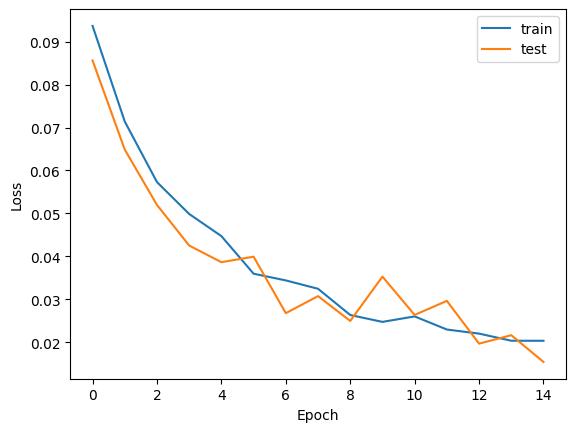

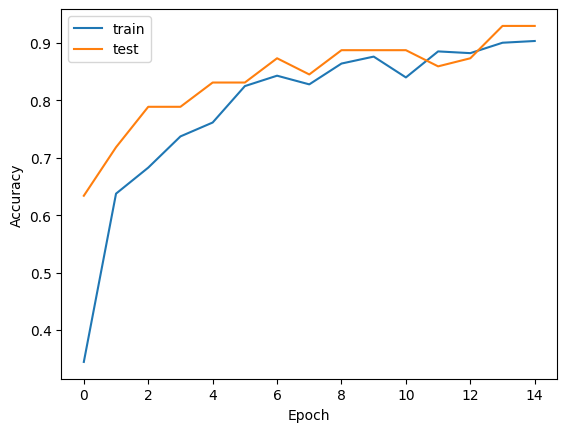

In [ ]:
epoch = 15
model_path = '/content/drive/My Drive/PaymentReceipt/model'
file_output_path = model_path + '/vgg13_bn_{:02}.pth'
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model_vgg13_bn.parameters(), lr=0.001, momentum=0.9)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=2000, gamma=0.1)

if not os.path.isdir(model_path):
   os.makedirs(model_path)

# Starting model
training(model_vgg13_bn, epoch, file_output_path, optimizer)

In [ ]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report

def plot_confusion_matrix(cm, y_true, y_pred, classes):

    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=classes, yticklabels=classes)
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.title('Confusion Matrix')
    plt.show()

def clf_report(target ,pred):
    cm = confusion_matrix(target, pred)
    plot_confusion_matrix(cm,target, pred, class_names)
    print (classification_report(target ,pred))

def detail_eval(model, dataset_loader):

  device = check_gpu()
  model = model.to(device)

  model.eval()

  teach_labels_array = []
  pred_labels_array = []

  with torch.no_grad():
    for data, target in dataset_loader:

      input_datas, labels = data.to(device), target.to(device)

      predicted = model(input_datas)

      pred_labels = torch.max(predicted, 1)

      teach_labels_array.extend(labels.cpu().numpy())
      pred_labels_array.extend(pred_labels[1].cpu().numpy())

  # Confusion-Matrix & Classification_report
  clf_report(teach_labels_array, pred_labels_array)

<ipython-input-12-0411e0b594ba>:6: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model_vgg13_bn.load_state_dict(torch.load(load_path))


-------CPU Mode--------


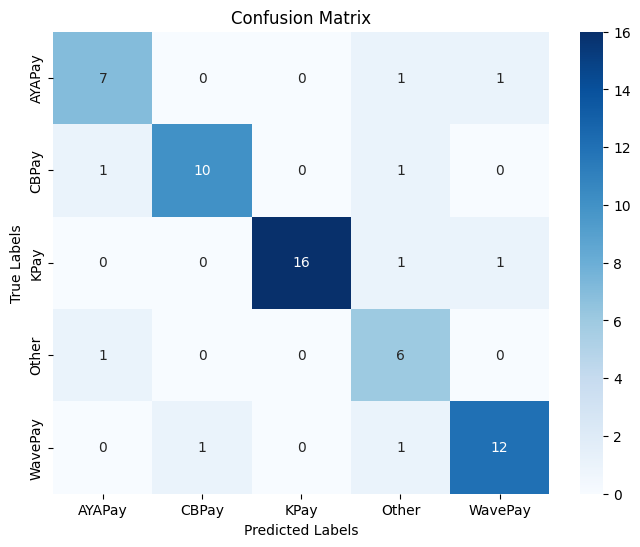

              precision    recall  f1-score   support

           0       0.78      0.78      0.78         9
           1       0.91      0.83      0.87        12
           2       1.00      0.89      0.94        18
           3       0.60      0.86      0.71         7
           4       0.86      0.86      0.86        14

    accuracy                           0.85        60
   macro avg       0.83      0.84      0.83        60
weighted avg       0.87      0.85      0.86        60

-------CPU Mode--------


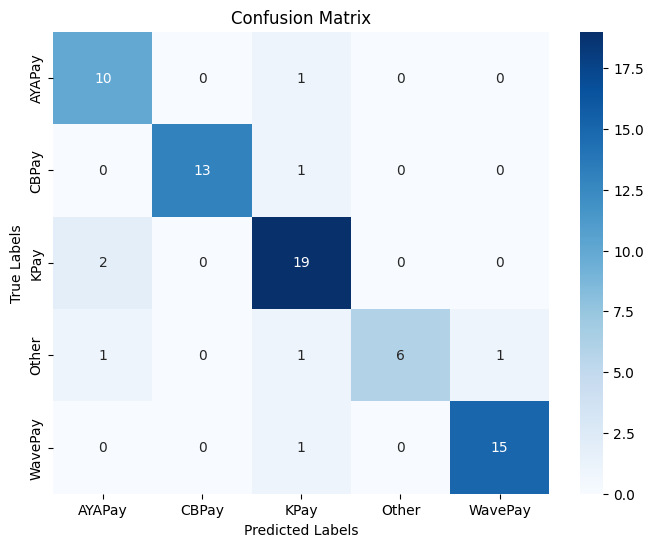

              precision    recall  f1-score   support

           0       0.77      0.91      0.83        11
           1       1.00      0.93      0.96        14
           2       0.83      0.90      0.86        21
           3       1.00      0.67      0.80         9
           4       0.94      0.94      0.94        16

    accuracy                           0.89        71
   macro avg       0.91      0.87      0.88        71
weighted avg       0.90      0.89      0.89        71



In [ ]:
import torchvision.models as models
import torch.nn as nn

load_path = model_path + '/vgg13_bn_13.pth'

model_vgg13_bn.load_state_dict(torch.load(load_path))

detail_eval(model_vgg13_bn, test_loader)
detail_eval(model_vgg13_bn, val_loader)

<ipython-input-40-ea8686a08cf1>:83: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(load_path))  # Load your trained model weights


Input data shape: torch.Size([1, 3, 224, 224])


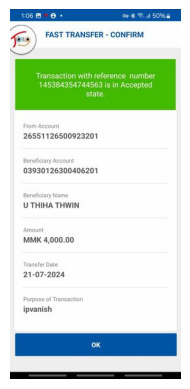

Other_1.jpg : Other
Input data shape: torch.Size([1, 3, 224, 224])


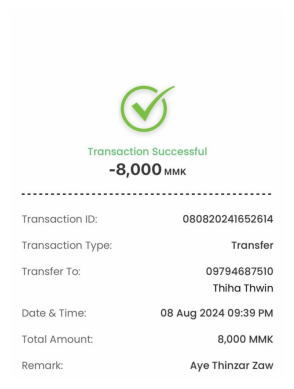

Other_28.jpg : Other
Input data shape: torch.Size([1, 3, 224, 224])


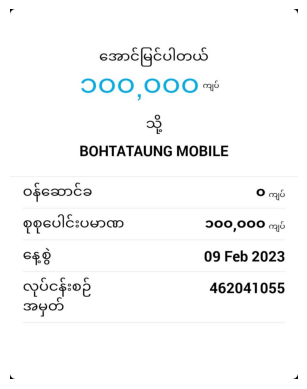

WavePay_64.jpg : WavePay
Input data shape: torch.Size([1, 3, 224, 224])


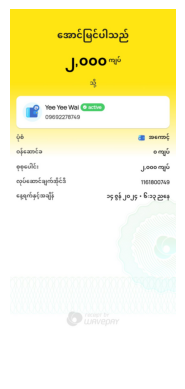

WavePay_25.jpg : WavePay
Input data shape: torch.Size([1, 3, 224, 224])


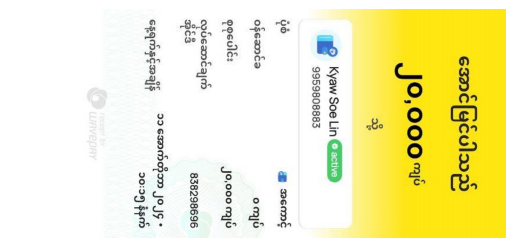

WavePay_79.jpg : WavePay
Input data shape: torch.Size([1, 3, 224, 224])


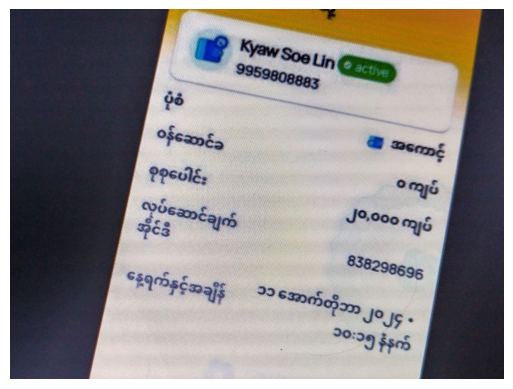

WavePay_102.jpg : WavePay
Input data shape: torch.Size([1, 3, 224, 224])


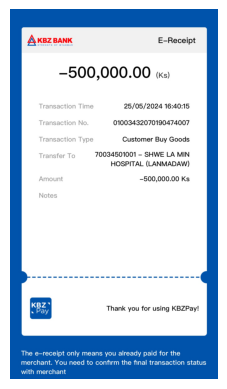

KPay_1.JPG : KPay
Input data shape: torch.Size([1, 3, 224, 224])


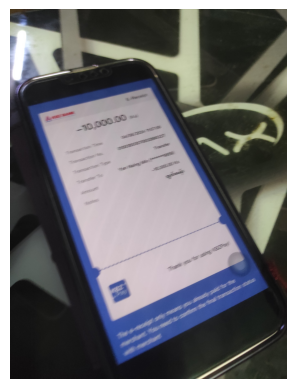

KPay_113.jpg : KPay
Input data shape: torch.Size([1, 3, 224, 224])


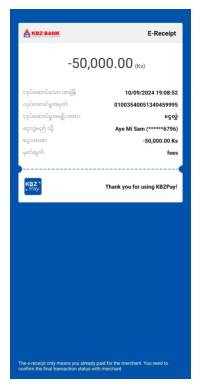

KPay_34.jpg : KPay
Input data shape: torch.Size([1, 3, 224, 224])


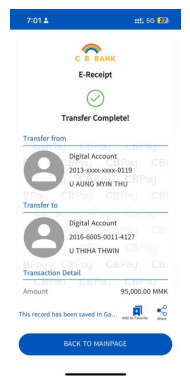

CBPay_0.jpg : CBPay
Input data shape: torch.Size([1, 3, 224, 224])


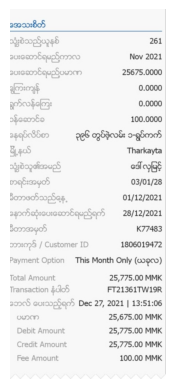

CBPay_38.jpg : CBPay
Input data shape: torch.Size([1, 3, 224, 224])


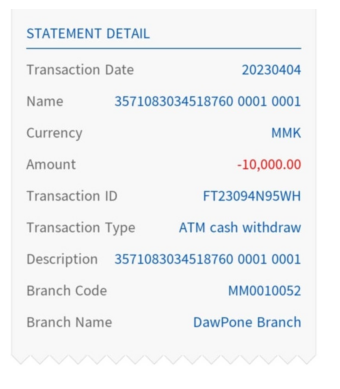

CBPay_62.jpg : CBPay
Input data shape: torch.Size([1, 3, 224, 224])


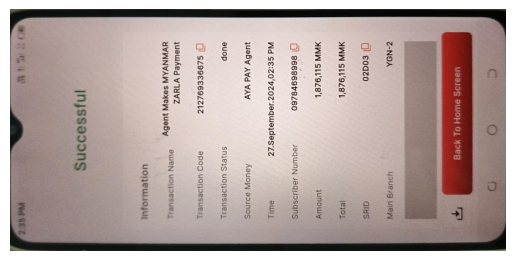

AYAPay_33.jpg : AYAPay
Input data shape: torch.Size([1, 3, 224, 224])


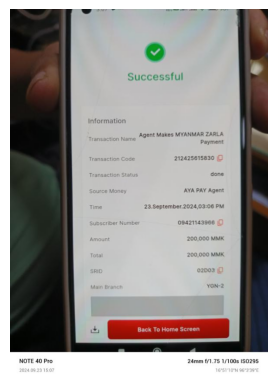

AYAPay_38.jpg : CBPay
Input data shape: torch.Size([1, 3, 224, 224])


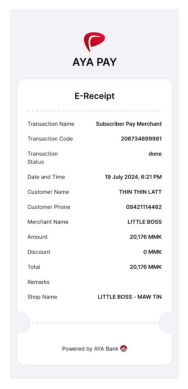

AYAPay_14.jpg : AYAPay


In [ ]:
import os
import glob
import torch
import torch.nn as nn
import torchvision.transforms as transforms
from torchvision import models
from PIL import Image
import cv2
import matplotlib.pyplot as plt

# Check for GPU
def check_gpu():
    return torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Load and preprocess the image
def processing_image(image_path):
    # Load the image
    img = Image.open(image_path)

    # Define preprocessing steps
    val_transform = transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406],
                             std=[0.229, 0.224, 0.225])
    ])

    # Apply preprocessing
    img_transformed = val_transform(img)  # torch.Size([3, 224, 224])
    inputs = img_transformed.unsqueeze(0)  # torch.Size([1, 3, 224, 224])

    return inputs

# Function to predict the model output
def predict_model(model, test_images_path, class_names):
    # Check for GPU
    device = check_gpu()
    model = model.to(device)

    # Switch to evaluation mode
    model.eval()

    with torch.no_grad():
        for img_path in test_images_path:
            dir, fileName = os.path.split(img_path)
            data = processing_image(img_path)
            input_data = data.to(device)

            # Check input shape
            print("Input data shape:", input_data.shape)  # Debugging line

            # Make predictions
            predicted = model(input_data)

            # Get the predicted class
            _, pred_label = torch.max(predicted, 1)

            # Convert index to class name
            label_name = class_names[pred_label.item()]

            # Display the image
            image = cv2.imread(img_path)
            image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
            plt.imshow(image_rgb)
            plt.axis('off')  # Hide axis
            plt.show()

            print(f"{fileName} : {label_name}")

# Set paths and class names
base_path = 'drive/My Drive/'
model_path = '/content/drive/My Drive/PaymentReceipt/model'
load_path = model_path + '/vgg13_bn_13.pth'
class_names = ('AYAPay', 'CBPay', 'KPay', 'Other', 'WavePay')

# Load test images
image_folder = os.path.join(base_path, 'PaymentReceipt/dataset/deploy test data')
test_images_path = glob.glob(image_folder + '/**/*')

# Load the trained model
model = models.vgg13_bn(pretrained=True)  # Load the VGG model with pre-trained weights
model.classifier[6] = nn.Linear(4096, len(class_names))  # Update the classifier layer
model.load_state_dict(torch.load(load_path))  # Load your trained model weights

# Run predictions
predict_model(model, test_images_path, class_names)